In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [3]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.preprocessing import (correct_units,rename_cmip6)

In [4]:
#%pip install git+https://github.com/jbusecke/cmip6_preprocessing.git

In [5]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    ds = rename_cmip6(ds)
    ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

In [6]:
#this function gets the latest version of our catalog
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [7]:
model_name = 'CNRM-ESM2-1'

In [8]:
#define location of weights file and image output here
#for other model, just change the name of the model
import sys,os
system_dir = "/home/jovyan"
model_dir = f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/{model_name}/"
wgtsdir = f"{system_dir}/DNN4Cli/ensembleMLP"#leave this unchanged 
imgdirHisto = f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/{model_name}/png_historical_{model_name}"
imgdir1prct = f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/{model_name}/png_1prctCO2_{model_name}"
imgdirabrupt4Co2 = f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/{model_name}/png_abrupt4prctCO2_{model_name}"
if(os.path.exists(wgtsdir)):
    print("weight dir exists")
else:
    sys.exit("weights directory is invalid")
if(os.path.exists(wgtsdir+'/vanillamodel_0.h5')):
    print("weight file exists")
else:
    sys.exit("weights directory is invalid:"+wgtsdir+'/vanillamodel_0.h5')   
    
if not os.path.exists(imgdirHisto):
    os.makedirs(imgdirHisto)
if not os.path.exists(imgdir1prct):
    os.makedirs(imgdir1prct)
if not os.path.exists(imgdirabrupt4Co2):
    os.makedirs(imgdirabrupt4Co2)

weight dir exists
weight file exists


In [9]:
%pwd

'/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1'

## A query for all data Needed to run all the variable and experiment under CESM2
for the other models and scenarios, please change the variable "source_id"

In [10]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [11]:
query_Omon_tauuo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id = model_name,
                 grid_label=['gn'],
                 variable_id=["tauuo"])
query_Omon_tauvo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id= model_name,
                 grid_label=['gn'],
                 variable_id=["tauvo"])
query_Omon_zos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id= model_name,
                 grid_label=['gn'],
                 variable_id=["zos"])
query_Ofx = dict(experiment_id=['1pctCO2','abrupt-4xCO2','historical'],
                 table_id=['Ofx'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id= model_name,
                 grid_label=['gn'],
                 variable_id =["deptho"])

## Retrieving and Saving Ofx as a an npz file

In [12]:
cat_Ofx = col.search(**query_Ofx) 
cat_Ofx_lat = latest_version(cat_Ofx)

In [13]:
cat_Ofx_lat

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-ESM2-1,1pctCO2,NaN,NaN,Ofx,r1i1p1f2,gn,deptho,NaN,v20181018,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-E...
1,CMIP6,CNRM-CERFACS,CNRM-ESM2-1,abrupt-4xCO2,NaN,NaN,Ofx,r1i1p1f2,gn,deptho,NaN,v20181026,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-E...


In [14]:
cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [15]:
#cat_Ofx_latest

In [16]:
set_dict_Ofx= cat_Ofx_latest.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [17]:
set_dict_Ofx.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Ofx'])

In [18]:
#It's preffered to use the experiment with the latest version
xr_Ofx = set_dict_Ofx[list(set_dict_Ofx.keys())[0]]
xr_Ofx.deptho.shape

(1, 75, 294, 362)

In [19]:
xr_Ofx

<xarray.Dataset>
Dimensions:     (axis_nbounds: 2, lev: 75, member_id: 1, nvertex: 4, x: 362, y: 294)
Coordinates:
    lat         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev         (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * member_id   (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lat  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lev_bounds  (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    deptho      (member_id, lev, y, x) float32 dask.array<chunksize=(1, 75, 294, 362), meta=np.ndarray>
Attributes: (12/54)
    name:                    /scratch/utmp/ftdir/seferian/eclis/transfers/CNR...
    Conventions:             CF-1.7 CMIP-6.2
    creation_date:           2018-07-11T11:45:31Z
    tracking_id:             hdl:21.14100/480fe52e-0fef-4f6d-84b6-29d653113eb0
    description:             DECK: abrupt-4xCO2
    title:                   CNRM-ESM2-1 model output prepared for CMIP6 / CM...
    ...                      ...
    dr2xml_md5sum:           789c0010d555326fb79e73c3e20c5d0e
    xios_commit:             1442-shuffle
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:    6.3.2
    intake_esm_varname:      ['deptho']
    intake_esm_dataset_key:  CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Ofx

In [45]:
lat = xr_Ofx.lat
lat.shape

(294, 362)

In [46]:
lon = xr_Ofx.lon

In [52]:
deptho = xr_Ofx.deptho[0,:,:,:].max(axis=0)
deptho.shape

(294, 362)

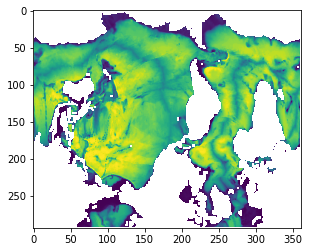

In [54]:
plt.imshow(deptho)

In [55]:
np.savez(str(model_name) +"_Ofx_lat_lon_deptho.npz", lat =lat ,lon= lon, deptho = deptho)

## Retrieving catalogs

In [24]:
cat_Omon_tauuo = col.search(**query_Omon_tauuo)
cat_Omon_tauuo_lat = latest_version(cat_Omon_tauuo)

cat_Omon_tauvo = col.search(**query_Omon_tauvo)
cat_Omon_tauvo_lat = latest_version(cat_Omon_tauvo)

cat_Omon_zos = col.search(**query_Omon_zos)
cat_Omon_zos_lat = latest_version(cat_Omon_zos)


In [25]:

cat_Omon_tauuo_latest = intake.open_esm_datastore(cat_Omon_tauuo_lat,esmcol_data=esmcol_data)
cat_Omon_tauvo_latest = intake.open_esm_datastore(cat_Omon_tauvo_lat,esmcol_data=esmcol_data)
cat_Omon_zos_latest = intake.open_esm_datastore(cat_Omon_zos_lat,esmcol_data=esmcol_data)


In [26]:
set_dict_zos = cat_Omon_zos_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [27]:
set_dict_tauuo = cat_Omon_tauuo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})
set_dict_tauvo = cat_Omon_tauvo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [28]:
list(set_dict_zos.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

In [29]:
list(set_dict_tauuo.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon']

In [30]:
list(set_dict_tauvo.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

In [31]:
#key assignment for each experiment
for i in list(set_dict_zos.keys()):
    if "historical" in i:
        historical = i
    if "abrupt" in i:
        abrupt = i
    if "1pctCO2" in i:
        oneCO2 = i

### Preparing the features for the EnsembleMLP

In [32]:
def grad(d,y,x):
    "Returns a three point derivative."
    g0, g1 = np.gradient(d)
    grady=g0/y
    gradx=g1/x
    return grady, gradx

In [33]:
Ofx = deptho
####
lonRoll = np.roll(Ofx.lon.values, axis=1, shift=-1)
Londiff = lonRoll - Ofx.lon.values
latDiff=1.111774765625000e+05
latY=np.gradient(Ofx.lat.values, axis=0)*latDiff
lonX=np.abs(np.cos(Ofx.lat.values*np.pi/180))*latDiff*Londiff
####
Omega=7.2921e-5
f=(2*Omega*np.sin(Ofx.lat.values*np.pi/180))

In [34]:
from pickle import load
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))
scaler = load(open(f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/scaler_v1.pkl", 'rb'))

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [35]:
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [36]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

In [37]:
ecco_label = np.load(f"{system_dir}/DNN4Cli/THOR/ApplicationOnCMIPModels/eccolabel.npy")

In [38]:
def list_of_years(end_year, duration, chunk_years):
    "This function create a list of chuncks years for a certain duration"
    "ex: list of 20 chunck years for a durationof 100 years"
    lst = []
    year = end_year
    for i in range(duration//chunk_years):
        lst.append(str("{:0>4}".format(year)))
        year= (year - chunk_years+1)
        lst.append(str("{:0>4}".format(year)))
        year= year-1
      
    lst.reverse()
    return lst

## Running Historical

## Historical Data for zos,tauuo, and tauvo

In [73]:
xr_zos_Histo = set_dict_zos[historical]
xr_tauuo_Histo = set_dict_tauuo[historical]
xr_tauvo_Histo = set_dict_tauvo[historical]

In [74]:
#xr_zos_Histo

In [75]:
#Checking the time period for this model and use the past years 150 for your predictions
xr_zos_Histo.zos.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-08-16 12:00:00,2014-08-16 12:00:00
2014-09-16 00:00:00,2014-09-16 00:00:00
2014-10-16 12:00:00,2014-10-16 12:00:00


In [76]:
#for historical experiements
listyears = list_of_years(end_year = 2011, duration = 140, chunk_years=20)
print(listyears)

['1872', '1891', '1892', '1911', '1912', '1931', '1932', '1951', '1952', '1971', '1972', '1991', '1992', '2011']


## Making some plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


28.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


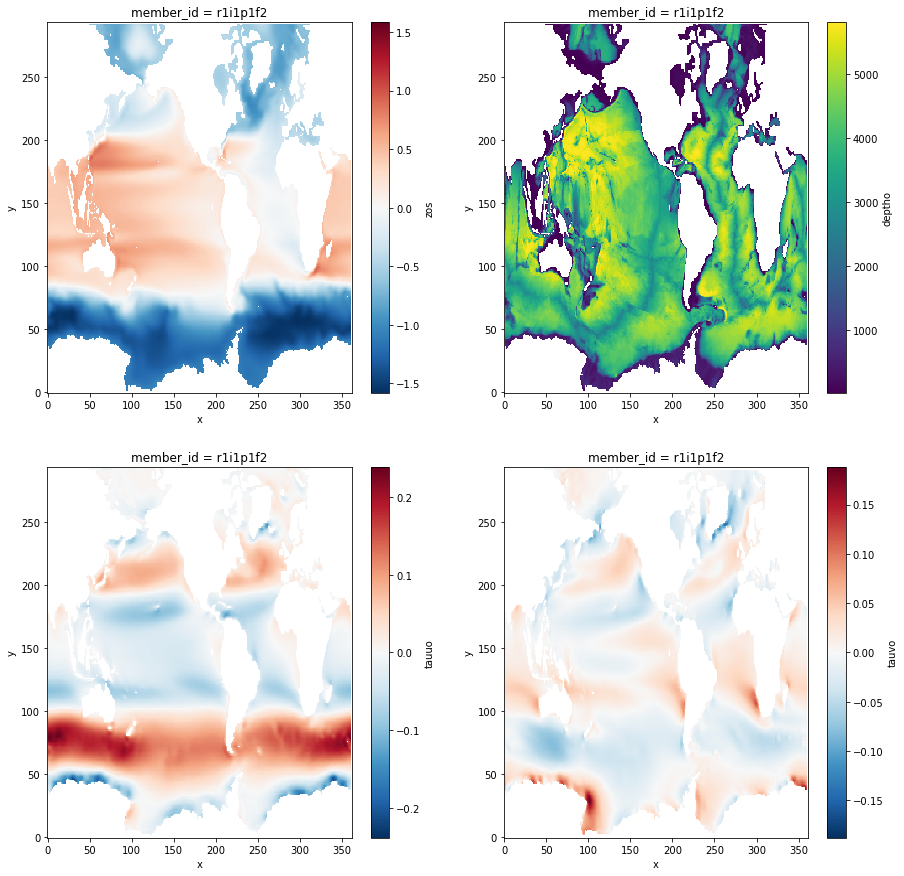

In [77]:
%%timeit -n1 -r1
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
xr_zos_Histo.zos.sel(time=slice(listyears[-2], listyears[-1])).mean(axis=1).plot()

plt.subplot(2,2,2)
deptho.plot()

plt.subplot(2,2,3)
xr_tauuo_Histo.tauuo.sel(time=slice(listyears[-2], listyears[-1])).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_Histo.tauvo.sel(time=slice(listyears[-2], listyears[-1])).mean(axis=1).plot()

In [ ]:
#%%timeit -n1 -r1
datapredicted_results_Histo = np.nan * np.zeros((7,)+Ofx.shape)
for i in range(7):
    
    print(listyears[2*i]+listyears[2*i+1])
    SSH20Mean = xr_zos_Histo.zos.isel(member_id=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_Histo.tauuo.isel(member_id=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_Histo.tauvo.isel(member_id=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_Histo[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

#directory to save the predicted can be changed based on the model and scenarios   
np.save(str(model_dir) + f"{model_name}-Historical-{listyears[0]}01-{listyears[-1]}12-EnsembleMLP.npy",datapredicted_results_Histo)
    

In [79]:
datapredicted_results_Histo.shape

(7, 294, 362)

Text(0.5, 1.0, 'ECCO regimes 1992-2011 Historical')

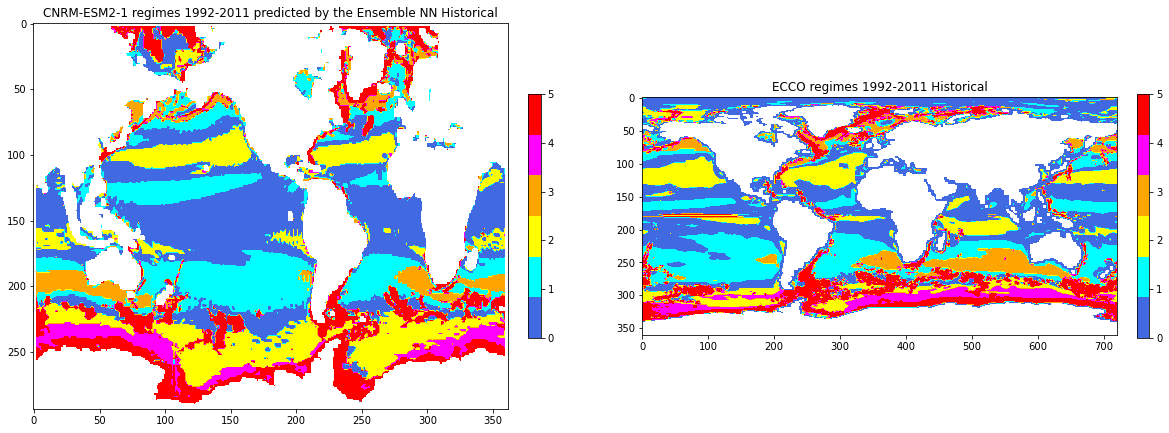

In [80]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_Histo[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"{model_name} regimes {listyears[-2]}-{listyears[-1]} predicted by the Ensemble NN Historical")

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"ECCO regimes {listyears[-2]}-{listyears[-1]} Historical")

# Save the images for the 20 years chunks

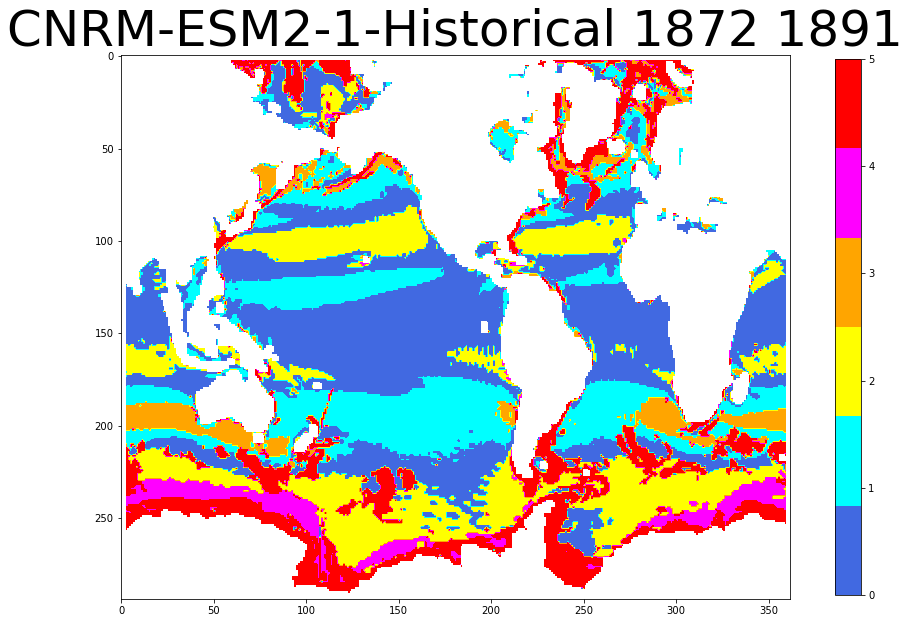

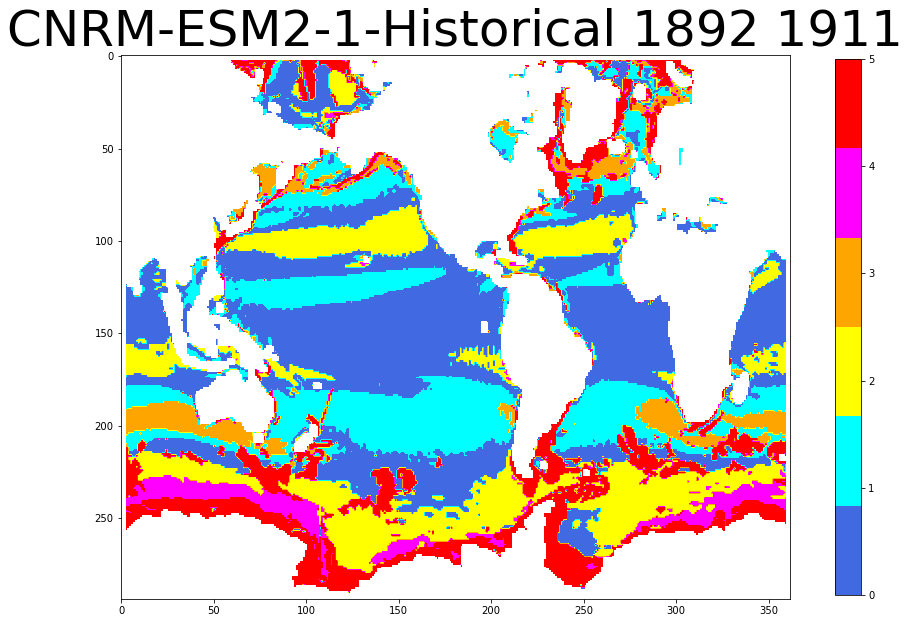

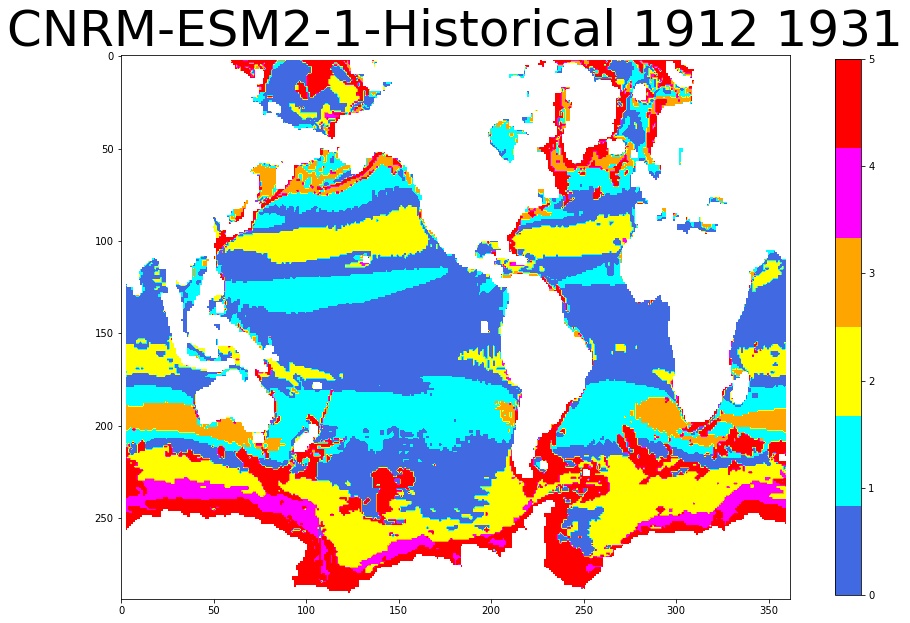

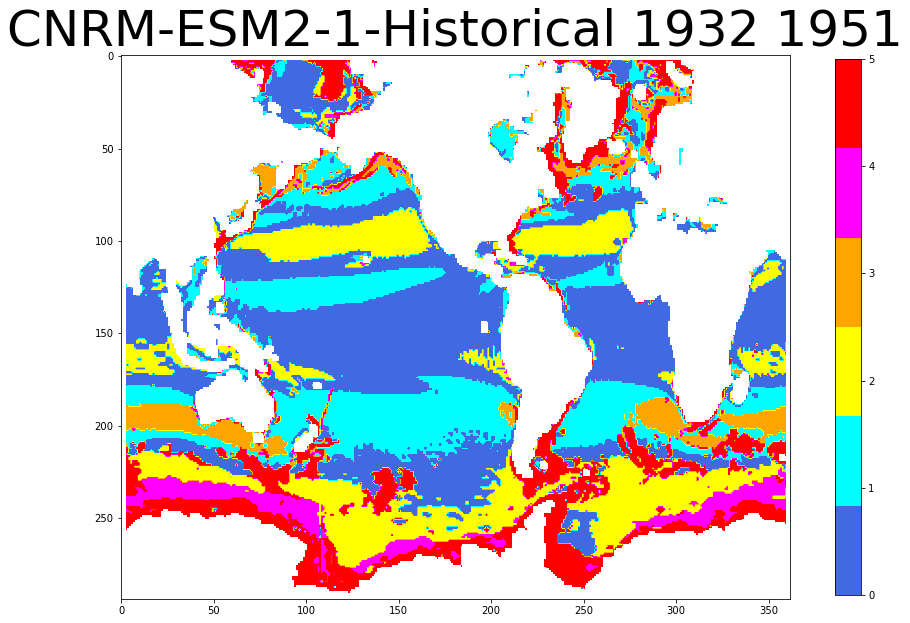

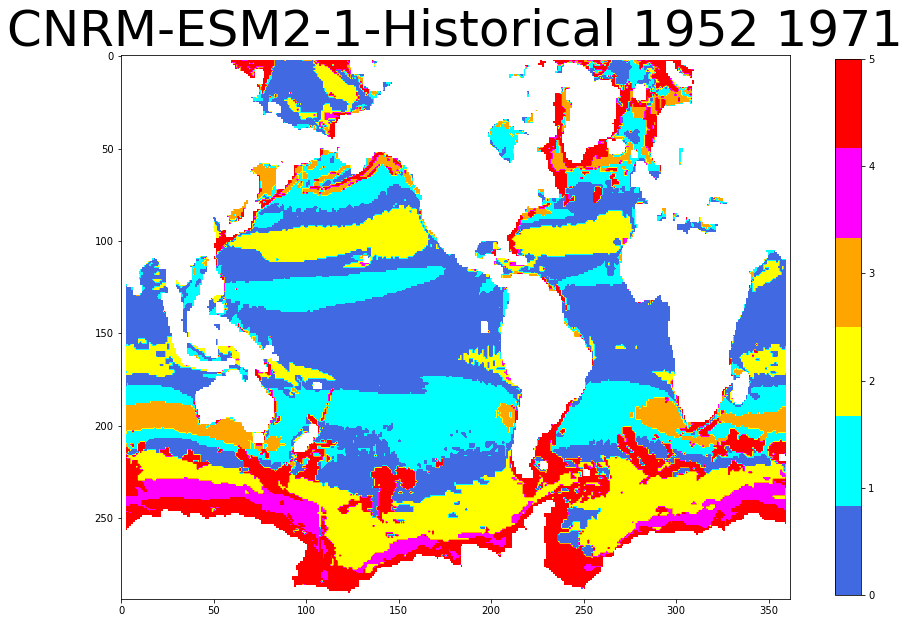

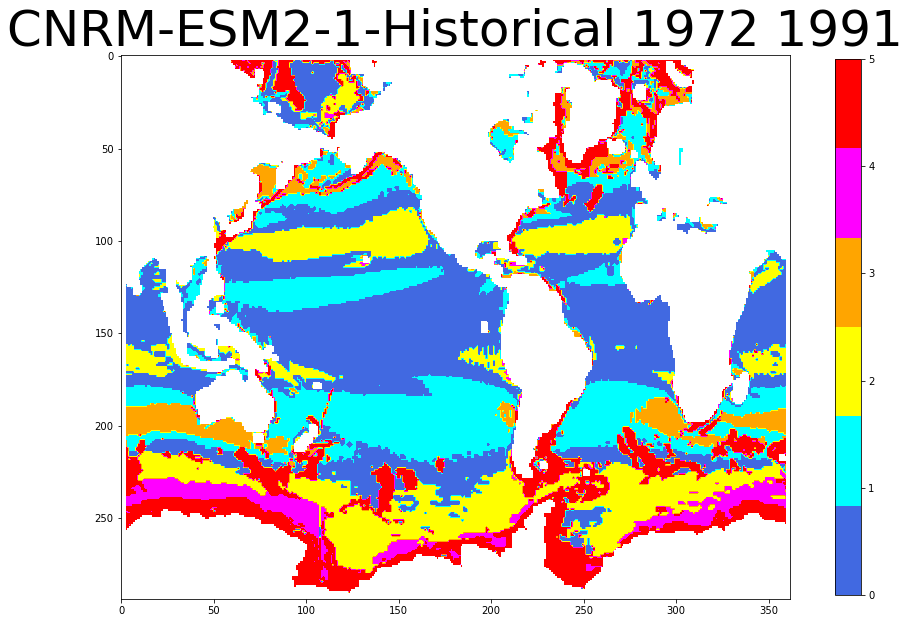

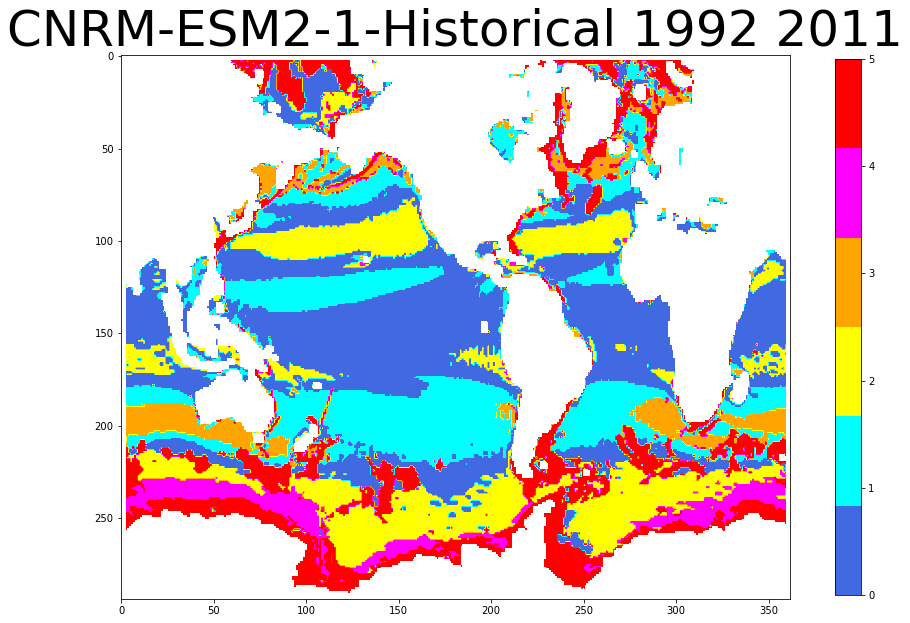

In [81]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_Histo[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title(f"{model_name}-Historical "+str(listyears[2*i])+' '+str(listyears[2*i+1]), fontsize=50)
    plt.savefig(imgdirHisto+"/"+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [82]:
import os
import imageio

png_dir = imgdirHisto+"/"
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(png_dir+ f"{model_name}-png_Historical.gif", images, fps=1)

## Running 1%CO2

## 1%CO2 Data for zos,tauuo, and tauvo

In [39]:
xr_zos_1prctCO2 = set_dict_zos[oneCO2]
xr_tauuo_1prctCO2 = set_dict_tauuo[oneCO2]
xr_tauvo_1prctCO2 = set_dict_tauvo[oneCO2]

In [42]:
xr_tauuo_1prctCO2.info()

xarray.Dataset {
dimensions:
	axis_nbounds = 2 ;
	member_id = 1 ;
	nvertex = 4 ;
	time = 1800 ;
	x = 362 ;
	y = 294 ;

variables:
	float64 lat(y, x) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:bounds = bounds_lat ;
	float64 lon(y, x) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:bounds = bounds_lon ;
	float64 bounds_lon(y, x, nvertex) ;
	float64 bounds_lat(y, x, nvertex) ;
	object time(time) ;
		time:axis = T ;
		time:standard_name = time ;
		time:long_name = Time axis ;
		time:time_origin = 1850-01-01 00:00:00 ;
		time:bounds = time_bounds ;
	object time_bounds(time, axis_nbounds) ;
	float32 tauuo(member_id, time, y, x) ;
		tauuo:standard_name = surface_downward_x_stress ;
		tauuo:long_name = Surface Downward X Stress ;
		tauuo:units = N m-2 ;
		tauuo:online_operation = average ;
		tauuo:cell_methods = time: mean ;
		tauuo:interval_operation = 1800 s ;
		tauuo:interval_write 

In [85]:
xr_zos_1prctCO2.zos.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


In [43]:
#for 1%CO2experiments
listyears1prct = list_of_years(end_year= 1998, duration=140, chunk_years=20)
print(listyears1prct)

['1859', '1878', '1879', '1898', '1899', '1918', '1919', '1938', '1939', '1958', '1959', '1978', '1979', '1998']


## Making some  plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


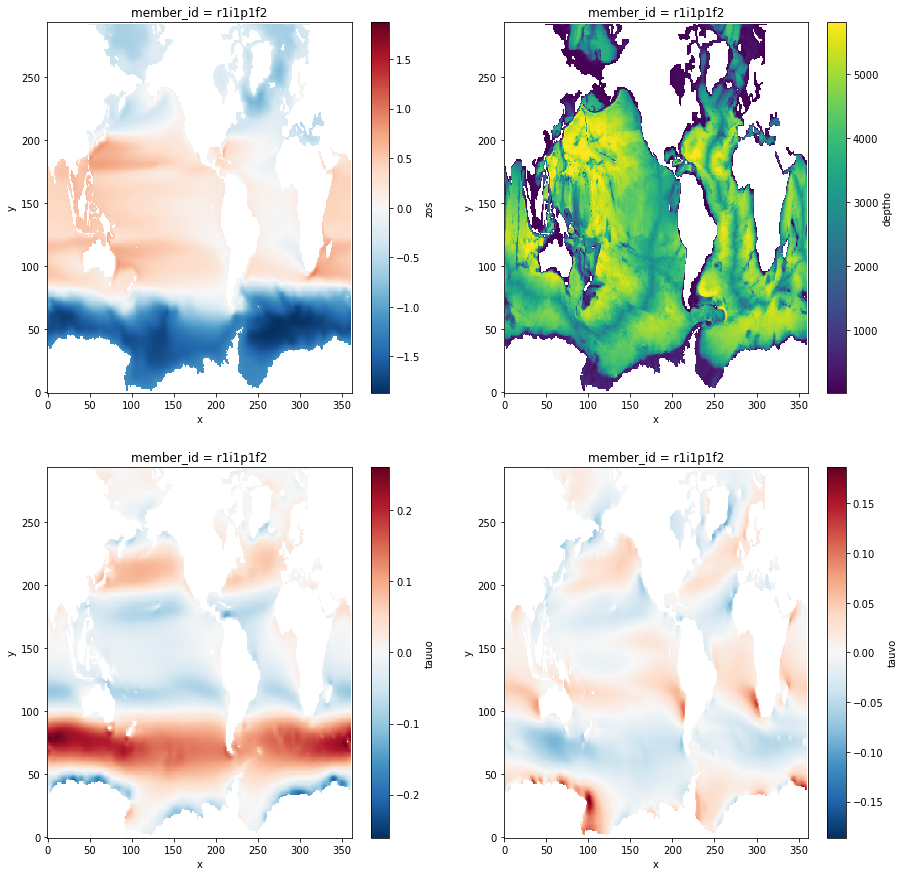

In [56]:
#sel(time=slice("1992", "2011"), the last 20 year chunck might differ based on the model experiments
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_1prctCO2.zos.sel(time=slice(listyears1prct[-2], listyears1prct[-1])).mean(axis=1).plot()

plt.subplot(2,2,2)
deptho.plot()

plt.subplot(2,2,3)
xr_tauuo_1prctCO2.tauuo.sel(time=slice(listyears1prct[-2], listyears1prct[-1])).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_1prctCO2.tauvo.sel(time=slice(listyears1prct[-2], listyears1prct[-1])).mean(axis=1).plot()

## Predicting 1prctCO2...

In [57]:
datapredicted_results_1prctCO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears1prct[2*i]+listyears1prct[2*i+1])
    SSH20Mean = xr_zos_1prctCO2.zos.isel(member_id=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_1prctCO2.tauuo.isel(member_id=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_1prctCO2.tauvo.isel(member_id=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_1prctCO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save(model_dir + f"{model_name}-1prctCO2-{listyears1prct[0]}01-{listyears1prct[-1]}12-EnsembleMLP.npy",datapredicted_results_1prctCO2)


18591878


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18791898


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18991918


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19191938


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19391958


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19591978


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19791998


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'ECCO regimes 1979-1998 1prctCO2')

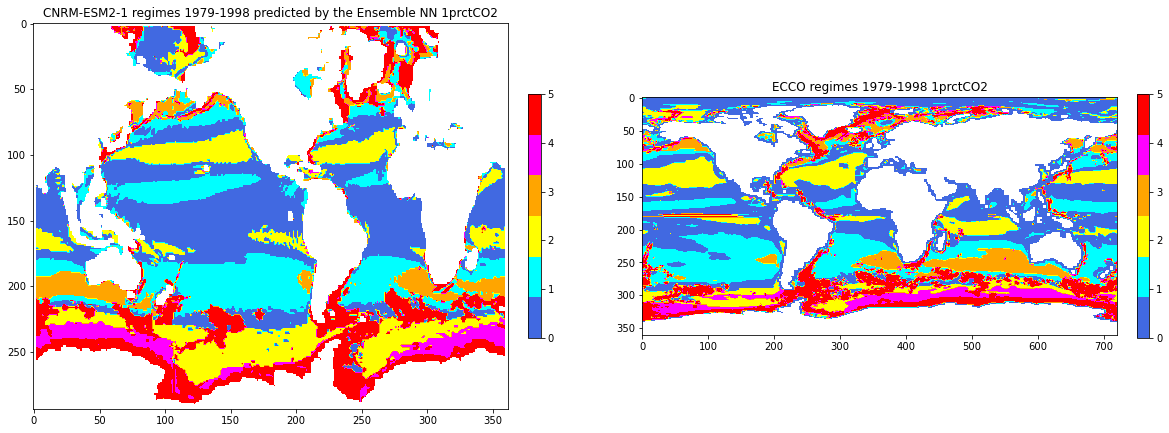

In [58]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_1prctCO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"{model_name} regimes {listyears1prct[-2]}-{listyears1prct[-1]} predicted by the Ensemble NN 1prctCO2")

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"ECCO regimes {listyears1prct[-2]}-{listyears1prct[-1]} 1prctCO2")

# Save the images for the 20 years chunks
change the saved directory if necessary for the output files

In [ ]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_1prctCO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title(f'{model_name}-1prctCO2 '+str(listyears1prct[2*i])+' '+str(listyears1prct[2*i+1]), fontsize=50)
    plt.savefig(imgdir1prct +'/'+str(listyears1prct[2*i])+str(listyears1prct[2*i+1])+'.png')

## create a gif

In [ ]:
import os
import imageio

png_dir = imgdir1prct +'/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(png_dir + f"{model_name}-png_1prctCO2.gif", images, fps=1)

## Running abrupt4xCO2

## abrupt-4xCO2 Data for zos,tauuo, and tauvo
the dictionary keys should be changed for other models and scenarios



In [59]:
xr_zos_abrupt4prctCO2 = set_dict_zos[abrupt]
xr_tauuo_abrupt4prctCO2 = set_dict_tauuo[abrupt]
xr_tauvo_abrupt4prctCO2 = set_dict_tauvo[abrupt]

In [65]:
#xr_tauvo_abrupt4prctCO2

In [67]:
xr_zos_abrupt4prctCO2.zos.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


In [68]:
#since abrupt 4xCO2 has the included 1%CCO2 years included, we will use the same year
#this is specific to this project
listyears4abruptprct = list_of_years(end_year= 1998, duration=140, chunk_years=20)
print(listyears4abruptprct)

['1859', '1878', '1879', '1898', '1899', '1918', '1919', '1938', '1939', '1958', '1959', '1978', '1979', '1998']


## Making some plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


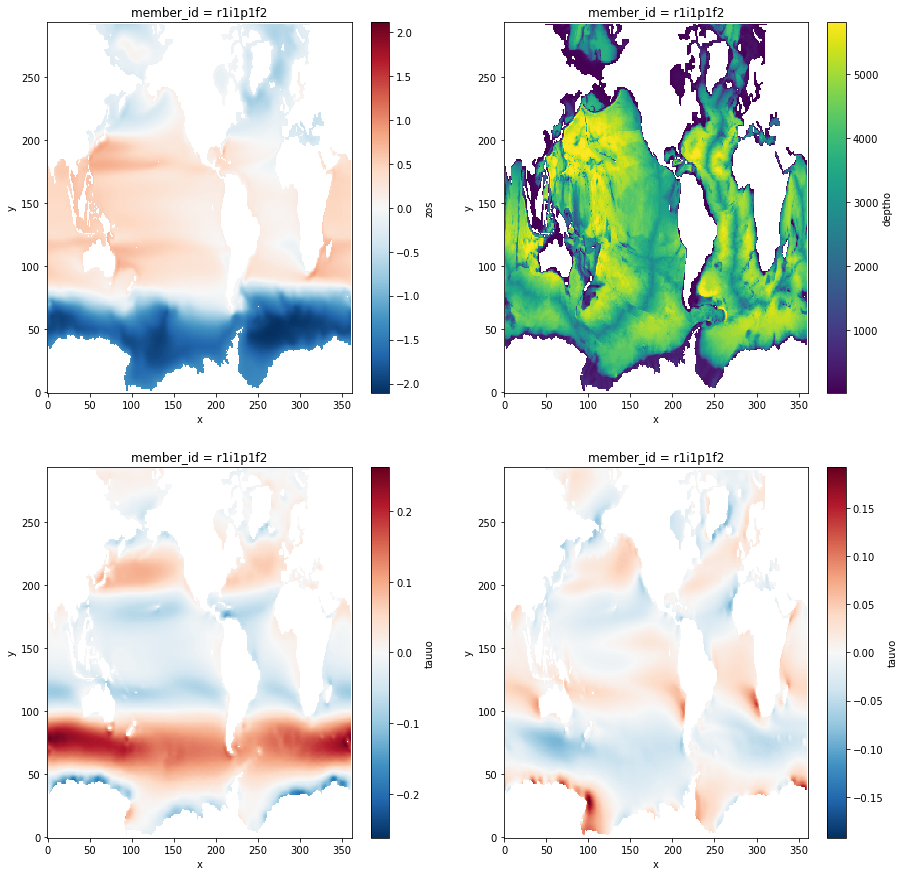

In [69]:
#sel(time=slice("1992", "2011")) I removed the date slice because it was gving me an empty plot. This is specific to 1prctCO2
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_abrupt4prctCO2.zos.sel(time=slice(listyears4abruptprct[-2], listyears4abruptprct[-1])).mean(axis=1).plot()

plt.subplot(2,2,2)
deptho.plot()#Specific to CESM2 model deptho

plt.subplot(2,2,3)
xr_tauuo_abrupt4prctCO2.tauuo.sel(time=slice(listyears4abruptprct[-2], listyears4abruptprct[-1])).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_abrupt4prctCO2.tauvo.sel(time=slice(listyears4abruptprct[-2], listyears4abruptprct[-1])).mean(axis=1).plot()

## Predicting abrupt-4xCO2...

In [ ]:
datapredicted_results_abrupt4CO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears4abruptprct[2*i]+listyears4abruptprct[2*i+1])
    SSH20Mean = xr_zos_abrupt4prctCO2.zos.isel(member_id=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_abrupt4prctCO2.tauuo.isel(member_id=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_abrupt4prctCO2.tauvo.isel(member_id=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_abrupt4CO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save( model_dir + f"{model_name}-abrupt4CO2-{listyears4abruptprct[0]}01-{listyears4abruptprct[-1]}12-EnsembleMLP.npy",datapredicted_results_abrupt4CO2)

    

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_abrupt4CO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"{model_name} regimes {listyears4abruptprct[-2]}-{listyears4abruptprct[-1]} predicted by the Ensemble NN abrupt4CO2")

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title(f"ECCO regimes {listyears4abruptprct[-2]}-{listyears4abruptprct[-1]} abrupt4CO2")

# Save the images for the 20 years chunks

In [ ]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_abrupt4CO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title(f"{model_name}-abrupt4CO2 ""+str(listyears4abruptprct[2*i])+' '+str(listyears4abruptprct[2*i+1]), fontsize=50)
    plt.savefig(imgdirabrupt4Co2+'/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [ ]:
import os
import imageio

png_dir = imgdirabrupt4Co2+'/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(png_dir + f"png_abrupt4prctCO2_{model_name}.gif", images, fps=1)